Credit card Fraud Detector
Введение
На данной практие (и еще на парочке занятий потом) мы будем реализовывать различные прогностические модели, чтобы проверить, насколько точно они определяют, является ли транзакция обычным платежом (non Fraud) или мошенничеством (Fraud).

По мотивам кейса, рассмотренного в Зимней школе СберУнивера
Наши цели:
Проанализировать полученные данные.
Рассмотреть проблему сильного дисбаланса классов.
Использовать алгоритмы кластеризации
Использовать алгоритмы понижения размерности

Задача: Банкам, выпускающим кредитные карты, очень важно распознавать мошеннические операции с кредитными картами, чтобы с клиентов не взималась плата за товары, которые они не покупали.

Данные: Набор данных содержит транзакции, совершенные по кредитным картам в сентябре 2013 года европейскими держателями карт. В этом наборе данных представлены транзакции, проведенные за два дня, где мы имеем 492 случаев мошенничества из 284 807 транзакций. Набор данных сильно несбалансирован, положительный класс (мошенники) составляет всего 0,172% от всех транзакций.

Датасет содержит только числовые входные переменные, которые являются результатом преобразования PCA (метод главных компонент).

Из-за вопросов конфиденциальности невозможно использовать исходные признаки и более подробную информацию о них. Характеристики V1, V2, ... V28 - это главные компоненты, полученные с помощью PCA, единственные характеристики, которые не были преобразованы с помощью PCA - это "Time" и "Amount". Столбец "Time" содержит секунды, прошедшие между каждой транзакцией и первой транзакцией в наборе данных. Столбец "Amount" - это сумма транзакции. Столбец "Class" является переменной отклика и принимает значение 1 в случае мошенничества и 0 в противном случае.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


import seaborn as sns
import matplotlib.patches as mpatches
import time

import collections
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/content/drive/MyDrive/data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Небольшой описательный анализ.

In [3]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [7]:
print(df['Class'].value_counts())

print(df['Class'].value_counts()[0])
print(df['Class'].value_counts()[1])

Class
0    284315
1       492
Name: count, dtype: int64
284315
492


In [8]:
total_tranzac=len(df)
normal_tranzac=len(df[df['Class']==0])
fraudulent_tranzac=len(df[df['Class']==1])
normal_perc=(normal_tranzac/total_tranzac)*100
fraudulen_perc=(fraudulent_tranzac/total_tranzac)*100

print(f'Обычные транзакции составляют  {normal_perc} % данных')
print(f'Мошеннические транзакции составляют  {fraudulen_perc} % данных')

Обычные транзакции составляют  99.82725143693798 % данных
Мошеннические транзакции составляют  0.1727485630620034 % данных


In [9]:
n_trans=len(df[df['Class']==0])
f_trans=len(df[df['Class']==1])

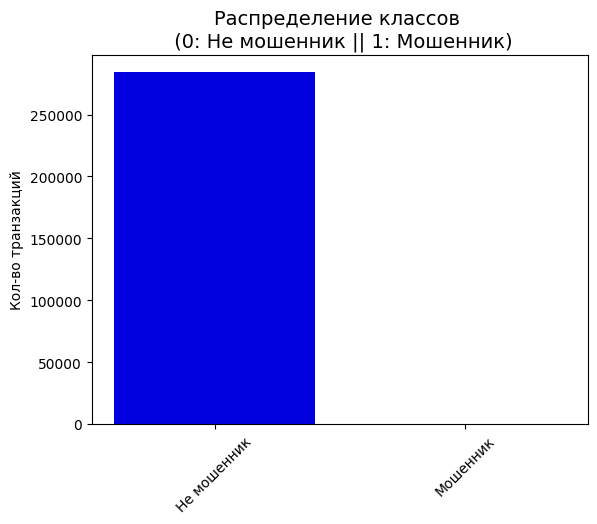

In [10]:
colors = ["#0101DF", "#DF0101"]

 # строим гистограмму целевой переменной:
plt.bar(['Не мошенник','Мошенник'],[n_trans,f_trans],color=colors)
plt.title('Распределение классов \n (0: Не мошенник || 1: Мошенник)', fontsize=14)
plt.ylabel('Кол-во транзакций')
plt.xticks(rotation=45)
plt.show()

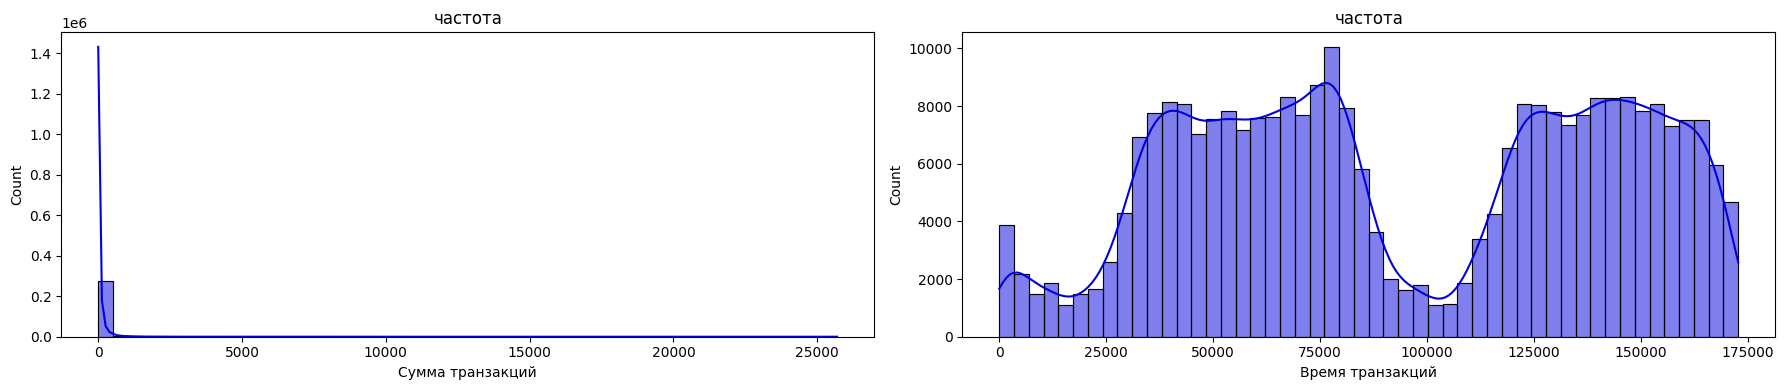

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount']
time_val = df['Time']

# ВАШ КОД ЗДЕСЬ # строим график распределения суммы транзакций
sns.histplot(amount_val,bins=50,kde=True,ax=ax[0],color='#0101DF')
ax[0].set_title('Распределение суммы транзакций', fontsize=14)
ax[0].set_xlabel('Сумма транзакций')
ax[0].set_title('частота')


# ВАШ КОД ЗДЕСЬ # строим график распределения времени транзакций
sns.histplot(time_val,bins=50,kde=True,ax=ax[1],color='#0101DF')
ax[1].set_title('Распределение времени транзакций', fontsize=14)
ax[1].set_xlabel('Время транзакций')
ax[1].set_title('частота')

plt.tight_layout()
plt.show()

Масштабирование
Первым делом нам необходимо отмасштабировать столбцы Time и Amount. Поскольку все остальные признаки уже отмасштабированы. Однако делать это нужно только строго после разбиения на обучающую выборку и тестовую.

Затем необходимо создать подвыборку из наших данных, чтобы иметь равное количество случаев мошенничества и не мошенничества, что поможет нашим моделям лучше понять закономерности, определяющие, является ли транзакция мошенничеством или нет.

Зачем создавать подвыборку?
Наши данные имеют сильный дисбаланс. Использование исходного датасета приведет к следующим проблемам:

Переобучение: Наши модели классификации будут предполагать, что в большинстве случаев мошенничества не существует! Мы хотим, чтобы наша модель точно определяла, когда происходит мошенничество.
Неверные корреляции: Хотя мы не знаем, что обозначают признаки "V", будет полезно понять, как каждый из этих признаков влияет на результат (мошенничество или отсутствие мошенничества), поскольку, имея несбалансированный набор данных, мы не можем увидеть истинные корреляции между целевой переменной и признаками.
Разделение данных
Важно!

Прежде, чем приступить к балансировке наших данных, мы должны разделить исходный набор данных. Зачем?

Для определения качества работы наших моделей их необходимо тестировать на исходном тестовом наборе, а не на тестовом наборе, созданном после балансировки. Цель балансировки заключается в том, чтобы модель смогла найти закономерности для принятия решения по типу транзакции, поэтому мы выравниваем соотношение между мошенническими транзакциями и обычными. Однако проверять качество мы будем именно в "боевых" условиях с учетом реального распределения данных.

In [12]:
from sklearn.model_selection import train_test_split
# Поскольку большая часть наших данных уже масштабирована, мы должны масштабировать столбцы,
# которые остались (Amount и Time)
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler() # Менее чувствителен к выбросам, чем просто стандартизация

X = df.drop('Class', axis=1)
y = df['Class']

original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2,
                                                                                    random_state = 42)


# Посмотрим, какие типы данных возвращаются после разделения:
rt_tmp = original_Xtrain['Amount']
print (f'Тип данных original_Xtrain["Amount"] {type(rt_tmp)}')
print (f'Тип данных original_Xtrain["Amount"].values {type(rt_tmp.values)}')
print (f'Данные original_Xtrain["Amount"].values {rt_tmp.values}')
print (f'Тип данных original_Xtrain["Amount"].values.reshape(-1,1) {type(rt_tmp.values.reshape(-1,1))}')
print (f'Данные original_Xtrain["Amount"].values.reshape(-1,1) \n{rt_tmp.values.reshape(-1,1)} \n')

# вот последнее представление - как раз то, что нужно для RobustScaler . Преобразовываем так все нужные столбцы.

original_Xtrain['scaled_amount'] = rob_scaler.fit_transform(original_Xtrain['Amount'].values.reshape(-1,1))
original_Xtest['scaled_amount'] = rob_scaler.fit_transform(original_Xtest['Amount'].values.reshape(-1,1))

original_Xtrain['scaled_time'] = rob_scaler.fit_transform(original_Xtrain['Time'].values.reshape(-1,1))
original_Xtest['scaled_time'] =rob_scaler.fit_transform(original_Xtest['Time'].values.reshape(-1,1))

original_Xtrain.drop(['Time','Amount'], axis=1, inplace=True)
original_Xtest.drop(['Time','Amount'], axis=1, inplace=True)

original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest,return_counts=True)

print('Распределение классов: \n')
print("Обучающий набор:", train_counts_label/ len(original_ytrain))
print("Тестовый набор:", test_counts_label/ len(original_ytest))

Тип данных original_Xtrain["Amount"] <class 'pandas.core.series.Series'>
Тип данных original_Xtrain["Amount"].values <class 'numpy.ndarray'>
Данные original_Xtrain["Amount"].values [  9.99  45.9   11.99 ...   3.94   1.   113.  ]
Тип данных original_Xtrain["Amount"].values.reshape(-1,1) <class 'numpy.ndarray'>
Данные original_Xtrain["Amount"].values.reshape(-1,1) 
[[  9.99]
 [ 45.9 ]
 [ 11.99]
 ...
 [  3.94]
 [  1.  ]
 [113.  ]] 

Распределение классов: 

Обучающий набор: [0.99827075 0.00172925]
Тестовый набор: [0.99827955 0.00172045]


Метод Random Under-Sampling
Применим метод Random Under-Sampling, который случайным образом удаляет объекты доминирующего класса и выравнивает соотношение классов.

Алгоритм:
Определяем степень несбалансированности (посчитали количество меток одного и другого класса выше)
Как только мы определим, сколько случаев считаются мошенническими операциями (Fraud = "1"), мы должны довести количество немошеннических операций до того же количества, что и мошеннических (мы хотим получить соотношение 50/50 между классами), то есть это в подвыборке будет 492 случая мошенничества и 492 случая немошеннических операций.
После применения этого метода мы получим подвыборку нашего набора данных с соотношением 50/50 в отношении наших классов. Наконец, не забудем перемешать наши данные для того, чтобы модели не зависили от порядка входных данных.
Важно!

Основная проблема данного метода заключается в том, что мы рискуем тем, что наши модели классификации не будут работать так точно, как нам хотелось бы, поскольку происходит большая потеря информации (выделение всего 492 немошеннических транзакций из 284 315 немошеннических транзакций).

In [14]:
# Поскольку наши классы сильно не сбалансированы, мы должны сделать их эквивалентными,
# чтобы получить нормальное распределение классов.

# Перемешаем данные перед созданием подвыборок

df = df.sample(frac=1)

fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492] # берем последние 492 транзакции

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Перемешивание строк датасета
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
57231,47816.0,1.200216,0.118330,0.563590,0.817746,0.013174,0.616752,-0.397075,0.141971,-0.011201,...,0.007969,0.041513,-0.186054,-1.014588,0.517047,-0.372589,0.054376,0.021428,26.07,0
42528,41138.0,-4.595617,5.083690,-7.581015,7.546033,-6.949165,-1.729185,-8.190192,2.714670,-7.083169,...,2.248971,0.566844,0.033744,0.591783,0.334229,0.386801,2.163898,0.983104,340.11,1
207378,136646.0,-0.622299,1.975647,0.454676,4.227290,0.621445,0.865095,0.299904,0.545710,-2.352047,...,-0.074249,-0.298864,0.231599,0.717824,-0.931453,-0.042037,0.062257,0.231351,7.80,0
8842,12093.0,-4.696795,2.693867,-4.475133,5.467685,-1.556758,-1.549420,-4.104215,0.553934,-1.498468,...,0.573898,-0.080163,0.318408,-0.245862,0.338238,0.032271,-1.508458,0.608075,0.00,1
122479,76575.0,-5.622469,3.480623,-6.200677,4.311234,-5.226286,-1.341764,-5.220941,2.682844,-2.921484,...,0.949569,-0.428986,-0.350676,0.197550,0.159234,-0.377791,-0.213562,0.459529,219.80,1


In [15]:
df = pd.read_csv('/content/drive/MyDrive/data/creditcard.csv')

In [16]:
new_df.shape

(984, 31)

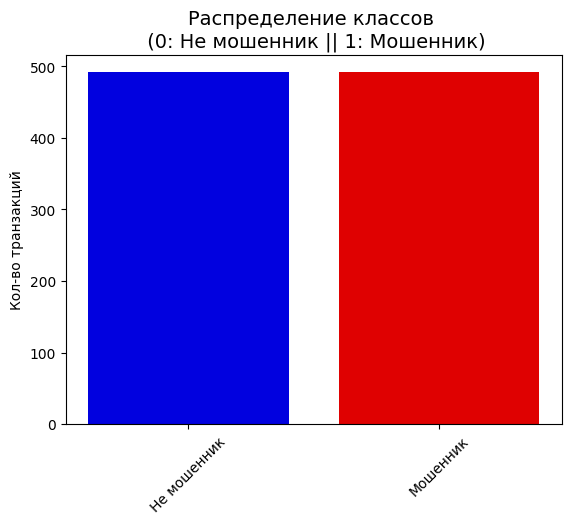

In [19]:
new_n_trans=len(new_df[new_df['Class']==0])
new_f_trans=len(new_df[new_df['Class']==1])
colors = ["#0101DF", "#DF0101"]

 # строим гистограмму целевой переменной:
plt.bar(['Не мошенник','Мошенник'],[new_n_trans,new_f_trans],color=colors)
plt.title('Распределение классов \n (0: Не мошенник || 1: Мошенник)', fontsize=14)
plt.ylabel('Кол-во транзакций')
plt.xticks(rotation=45)
plt.show()

# проверяем снова распределение целевой переменной



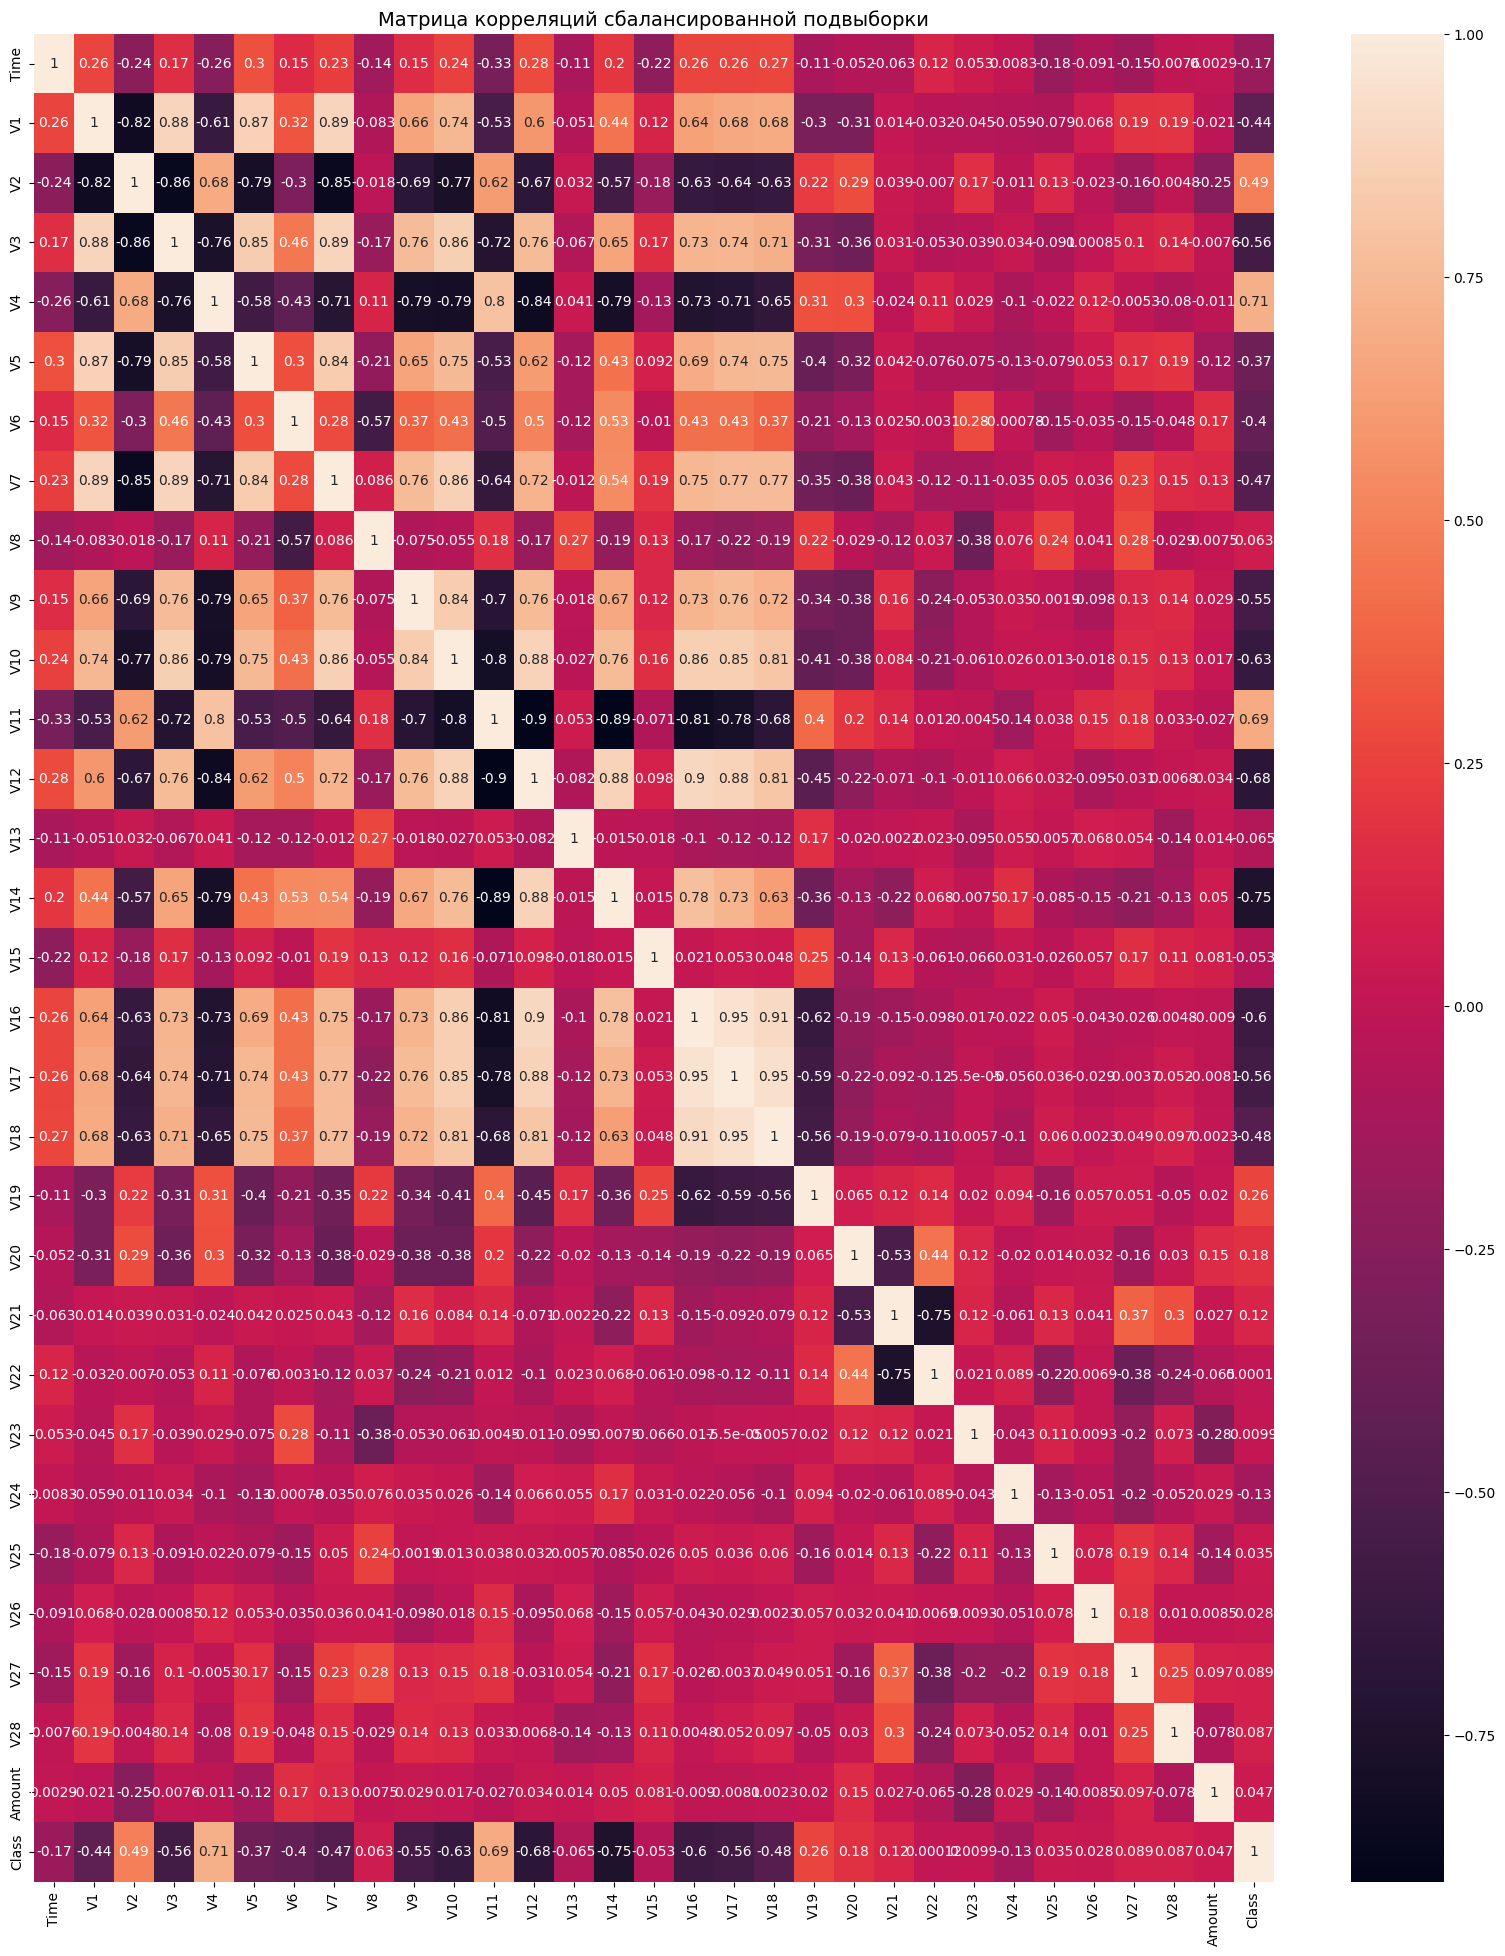

In [20]:
f, ax = plt.subplots(1, 1, figsize=(20, 24))

# Построим матрицу корреляций
corr_mat=new_df.corr()
sns.heatmap(corr_mat, annot=True)
ax.set_title('Матрица корреляций сбалансированной подвыборки', fontsize=14)
plt.show()



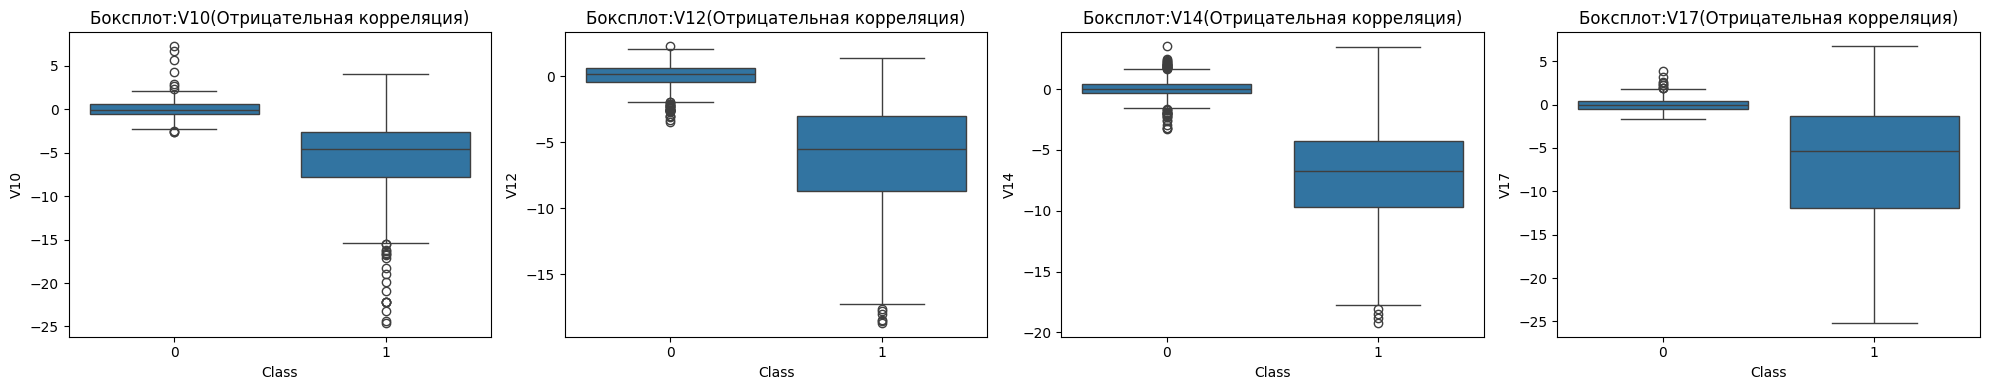

In [23]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))
negative=['V10','V12','V14','V17']
positive=['V2','V4','V11','V19']
# Отрицательные корреляции
#
for ax,feature in zip(axes,negative):
  sns.boxplot(x='Class',y=feature,data=new_df,ax=ax)
  ax.set_title(f'Боксплот:{feature}(Отрицательная корреляция)')
  ax.set_xlabel('Class')
  ax.set_ylabel(feature)

plt.tight_layout()
plt.show()


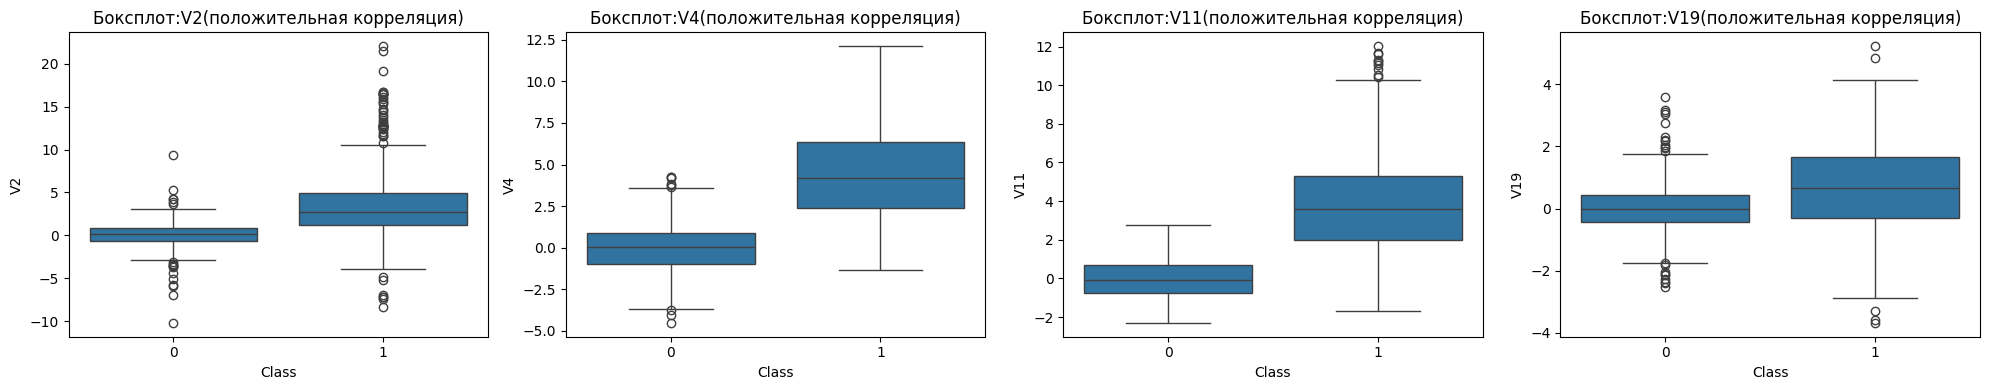

In [24]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))
negative=['V10','V12','V14','V17']
positive=['V2','V4','V11','V19']
# положительные корреляции
#
for ax,feature in zip(axes,positive):
  sns.boxplot(x='Class',y=feature,data=new_df,ax=ax)
  ax.set_title(f'Боксплот:{feature}(положительная корреляция)')
  ax.set_xlabel('Class')
  ax.set_ylabel(feature)

plt.tight_layout()
plt.show()




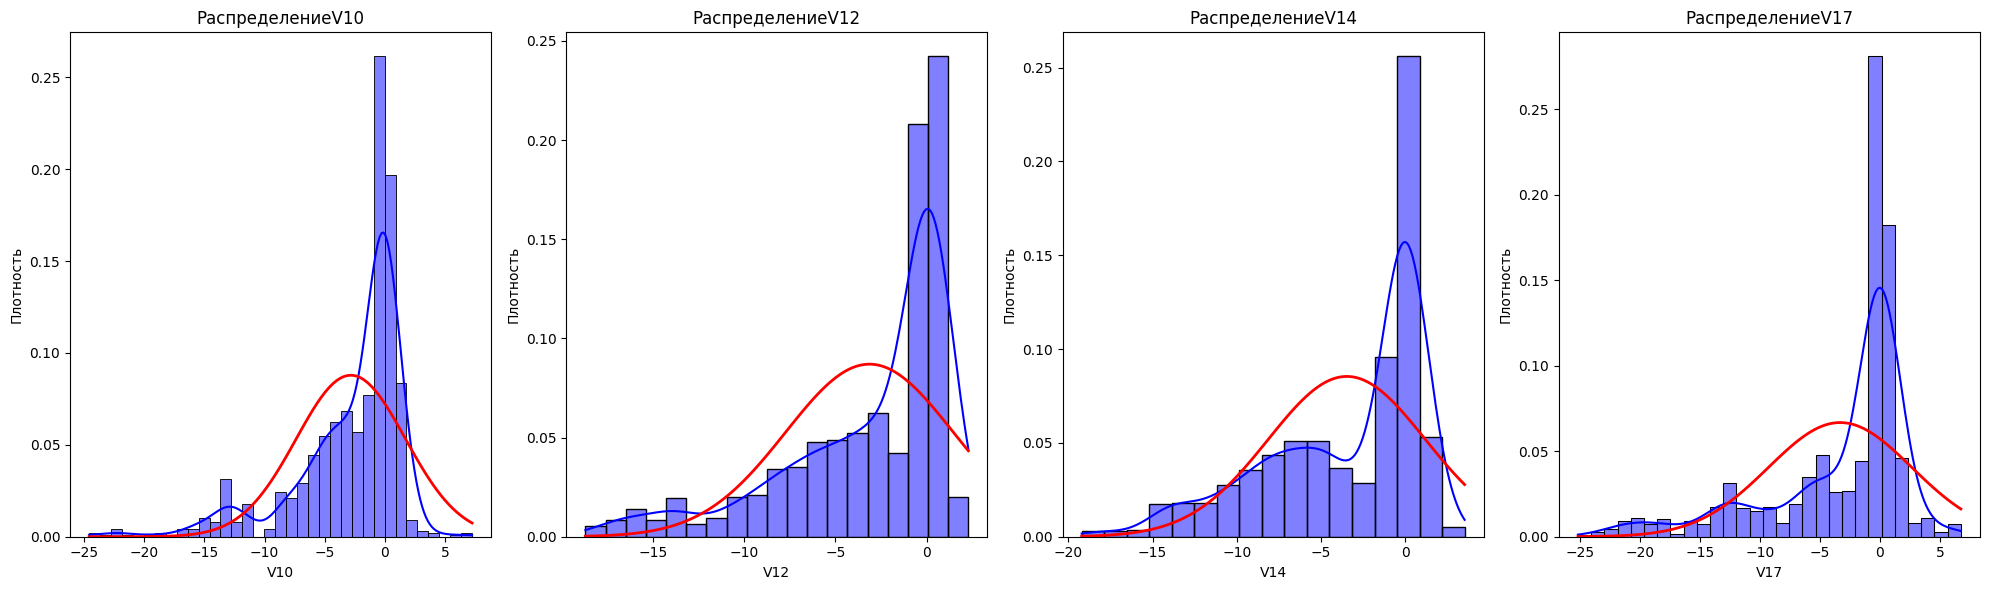

In [27]:
# Строим распределения для признаков с отрицательной корреляцией

from scipy.stats import norm

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20, 6))

####
for ax,feature in zip((ax1,ax2,ax3,ax4),negative):
  sns.histplot(new_df[feature],ax=ax,kde=True,stat="density",color='blue')
  mu,std=norm.fit(new_df[feature])
  x=np.linspace(new_df[feature].min(),new_df[feature].max(),100)
  p=norm.pdf(x,mu,std)
  ax.plot(x,p,'r',linewidth=2)
  ax.set_title(f'Распределение{feature}')
  ax.set_xlabel(feature)
  ax.set_ylabel('Плотность')
plt.tight_layout()
plt.show()


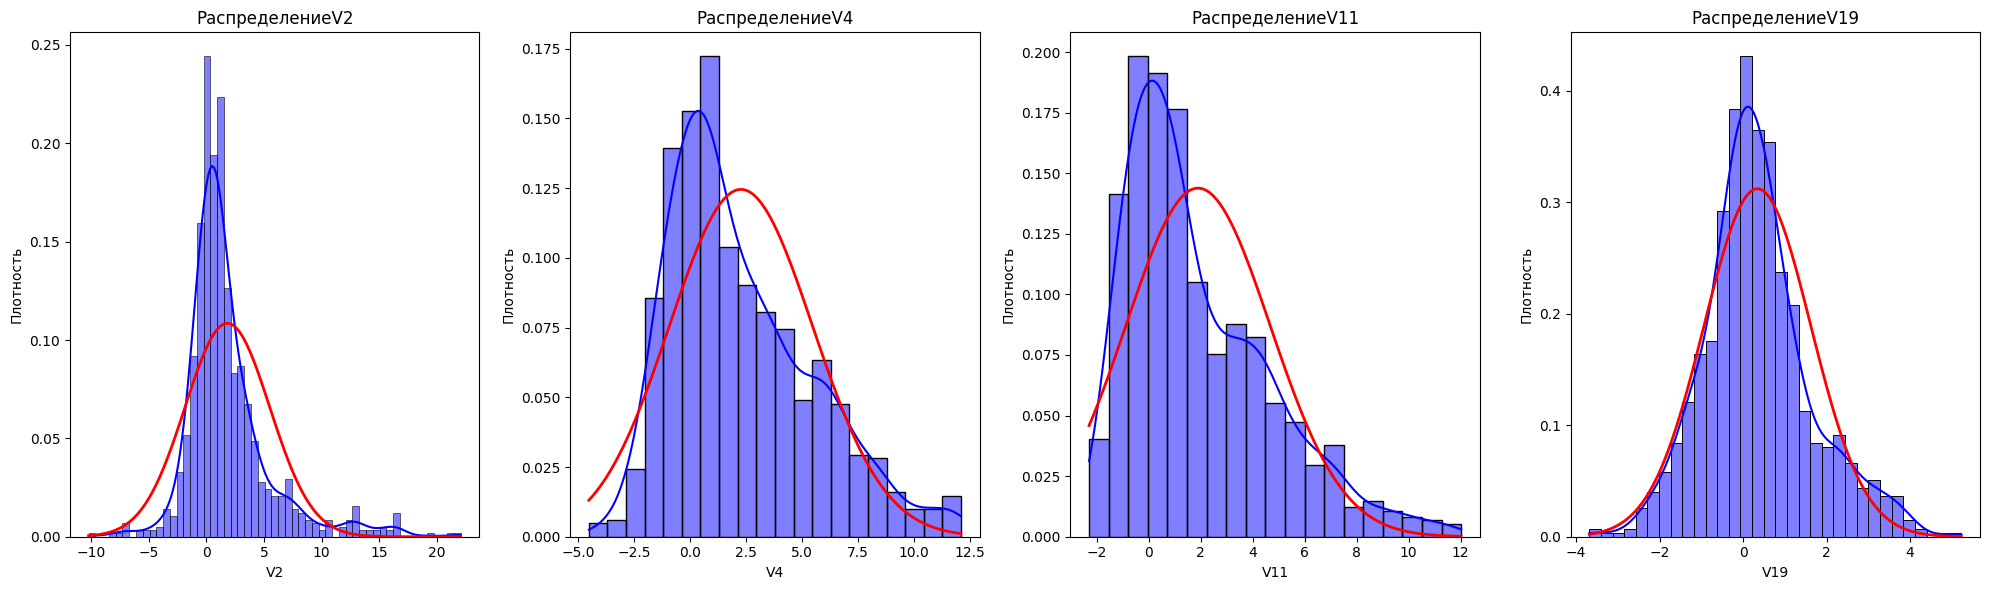

In [28]:
# Строим распределения для признаков с положительной корреляцией

from scipy.stats import norm

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20, 6))

####
for ax,feature in zip((ax1,ax2,ax3,ax4),positive):
  sns.histplot(new_df[feature],ax=ax,kde=True,stat="density",color='blue')
  mu,std=norm.fit(new_df[feature])
  x=np.linspace(new_df[feature].min(),new_df[feature].max(),100)
  p=norm.pdf(x,mu,std)
  ax.plot(x,p,'r',linewidth=2)
  ax.set_title(f'Распределение{feature}')
  ax.set_xlabel(feature)
  ax.set_ylabel('Плотность')
plt.tight_layout()
plt.show()


In [42]:
# Удаление выбросов из признака V17
def remove_shlak(df,feature,target_class):
  v17_fraud = df[feature].loc[df['Class'] == target_class].values

  q25, q75 = np.percentile(v17_fraud, 25), np.percentile(v17_fraud, 75)
  print('Квартиль 25: {} | Квартиль 75: {}'.format(q25, q75))
  v17_iqr = q75 - q25
  print('iqr: {}'.format(v17_iqr))

  v17_cut_off = v17_iqr * 1.5
  v17_lower, v17_upper = q25 - v17_cut_off, q75 + v17_cut_off
  print(f'Признак {feature}')
  print('Порог: {}'.format(v17_cut_off))
  print('нижняя граница: {}'.format(v17_lower))
  print('верхняя граница: {}'.format(v17_upper))
  print(f'Квартиль 25:{q25}; 75:{q75}')
  print(f'IQR :{v17_iqr}')
  outliers = df[(df[feature]>v17_upper)|(df[feature]<v17_lower)].index
  print('Количество выбросов: {}'.format(len(outliers)))
  df_w_outliers=df.drop(outliers)

  print('----' * 44)
  return df_w_outliers


#### Для остальных признаков на основе V17 описать функцию, в качастве параметра которой будут вытупать выбросы других признаков
### Написать вызов функции по нужным признакам

In [43]:
df_without_outliers=new_df.copy()

In [44]:
df_without_outliers

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
57231,47816.0,1.200216,0.118330,0.563590,0.817746,0.013174,0.616752,-0.397075,0.141971,-0.011201,...,0.007969,0.041513,-0.186054,-1.014588,0.517047,-0.372589,0.054376,0.021428,26.07,0
42528,41138.0,-4.595617,5.083690,-7.581015,7.546033,-6.949165,-1.729185,-8.190192,2.714670,-7.083169,...,2.248971,0.566844,0.033744,0.591783,0.334229,0.386801,2.163898,0.983104,340.11,1
207378,136646.0,-0.622299,1.975647,0.454676,4.227290,0.621445,0.865095,0.299904,0.545710,-2.352047,...,-0.074249,-0.298864,0.231599,0.717824,-0.931453,-0.042037,0.062257,0.231351,7.80,0
8842,12093.0,-4.696795,2.693867,-4.475133,5.467685,-1.556758,-1.549420,-4.104215,0.553934,-1.498468,...,0.573898,-0.080163,0.318408,-0.245862,0.338238,0.032271,-1.508458,0.608075,0.00,1
122479,76575.0,-5.622469,3.480623,-6.200677,4.311234,-5.226286,-1.341764,-5.220941,2.682844,-2.921484,...,0.949569,-0.428986,-0.350676,0.197550,0.159234,-0.377791,-0.213562,0.459529,219.80,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280149,169351.0,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,...,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,77.89,1
30100,35771.0,-3.218952,2.708535,-3.263042,1.361866,-1.645776,-1.852982,-3.069958,-1.796876,-0.213356,...,1.807877,-0.890421,-0.325814,0.123040,-0.093014,0.232106,-0.310519,-0.745295,60.60,1
265571,161945.0,2.020909,-0.832308,-0.167342,-1.391288,-1.278187,-0.892321,-0.900338,-0.047097,2.457610,...,0.084512,0.521410,0.253465,0.012939,-0.380382,-0.303718,0.057579,-0.032808,7.06,0
10498,17230.0,-0.469327,1.111453,2.041003,1.731595,0.135147,-0.093625,0.266155,0.082988,0.580255,...,0.159387,0.592670,-0.053596,0.320748,-0.369121,-0.136605,-0.100845,0.039347,3.93,1


In [45]:
for col in positive+negative:
  df_without_outliers=remove_shlak(df_without_outliers,col,1)

Квартиль 25: 1.1882258198658224 | Квартиль 75: 4.9712573249056025
iqr: 3.78303150503978
Признак V2
Порог: 5.67454725755967
нижняя граница: -4.486321437693848
верхняя граница: 10.645804582465273
Квартиль 25:1.1882258198658224; 75:4.9712573249056025
IQR :3.78303150503978
Количество выбросов: 51
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Квартиль 25: 2.232581359919345 | Квартиль 75: 6.070560404747405
iqr: 3.8379790448280597
Признак V4
Порог: 5.756968567242089
нижняя граница: -3.5243872073227442
верхняя граница: 11.827528971989494
Квартиль 25:2.232581359919345; 75:6.070560404747405
IQR :3.8379790448280597
Количество выбросов: 9
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Квартиль 25: 1.90399926160786 | Квартиль 75: 5.2678616038

In [46]:
df_without_outliers

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
57231,47816.0,1.200216,0.118330,0.563590,0.817746,0.013174,0.616752,-0.397075,0.141971,-0.011201,...,0.007969,0.041513,-0.186054,-1.014588,0.517047,-0.372589,0.054376,0.021428,26.07,0
207378,136646.0,-0.622299,1.975647,0.454676,4.227290,0.621445,0.865095,0.299904,0.545710,-2.352047,...,-0.074249,-0.298864,0.231599,0.717824,-0.931453,-0.042037,0.062257,0.231351,7.80,0
8842,12093.0,-4.696795,2.693867,-4.475133,5.467685,-1.556758,-1.549420,-4.104215,0.553934,-1.498468,...,0.573898,-0.080163,0.318408,-0.245862,0.338238,0.032271,-1.508458,0.608075,0.00,1
122479,76575.0,-5.622469,3.480623,-6.200677,4.311234,-5.226286,-1.341764,-5.220941,2.682844,-2.921484,...,0.949569,-0.428986,-0.350676,0.197550,0.159234,-0.377791,-0.213562,0.459529,219.80,1
193608,130211.0,2.309531,-0.576208,-2.820503,-1.173548,0.584042,-1.066171,0.337283,-0.467428,-1.119336,...,0.457790,1.326087,-0.364697,-0.955635,0.839493,0.345769,-0.107517,-0.113866,20.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280149,169351.0,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,...,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,77.89,1
30100,35771.0,-3.218952,2.708535,-3.263042,1.361866,-1.645776,-1.852982,-3.069958,-1.796876,-0.213356,...,1.807877,-0.890421,-0.325814,0.123040,-0.093014,0.232106,-0.310519,-0.745295,60.60,1
265571,161945.0,2.020909,-0.832308,-0.167342,-1.391288,-1.278187,-0.892321,-0.900338,-0.047097,2.457610,...,0.084512,0.521410,0.253465,0.012939,-0.380382,-0.303718,0.057579,-0.032808,7.06,0
10498,17230.0,-0.469327,1.111453,2.041003,1.731595,0.135147,-0.093625,0.266155,0.082988,0.580255,...,0.159387,0.592670,-0.053596,0.320748,-0.369121,-0.136605,-0.100845,0.039347,3.93,1


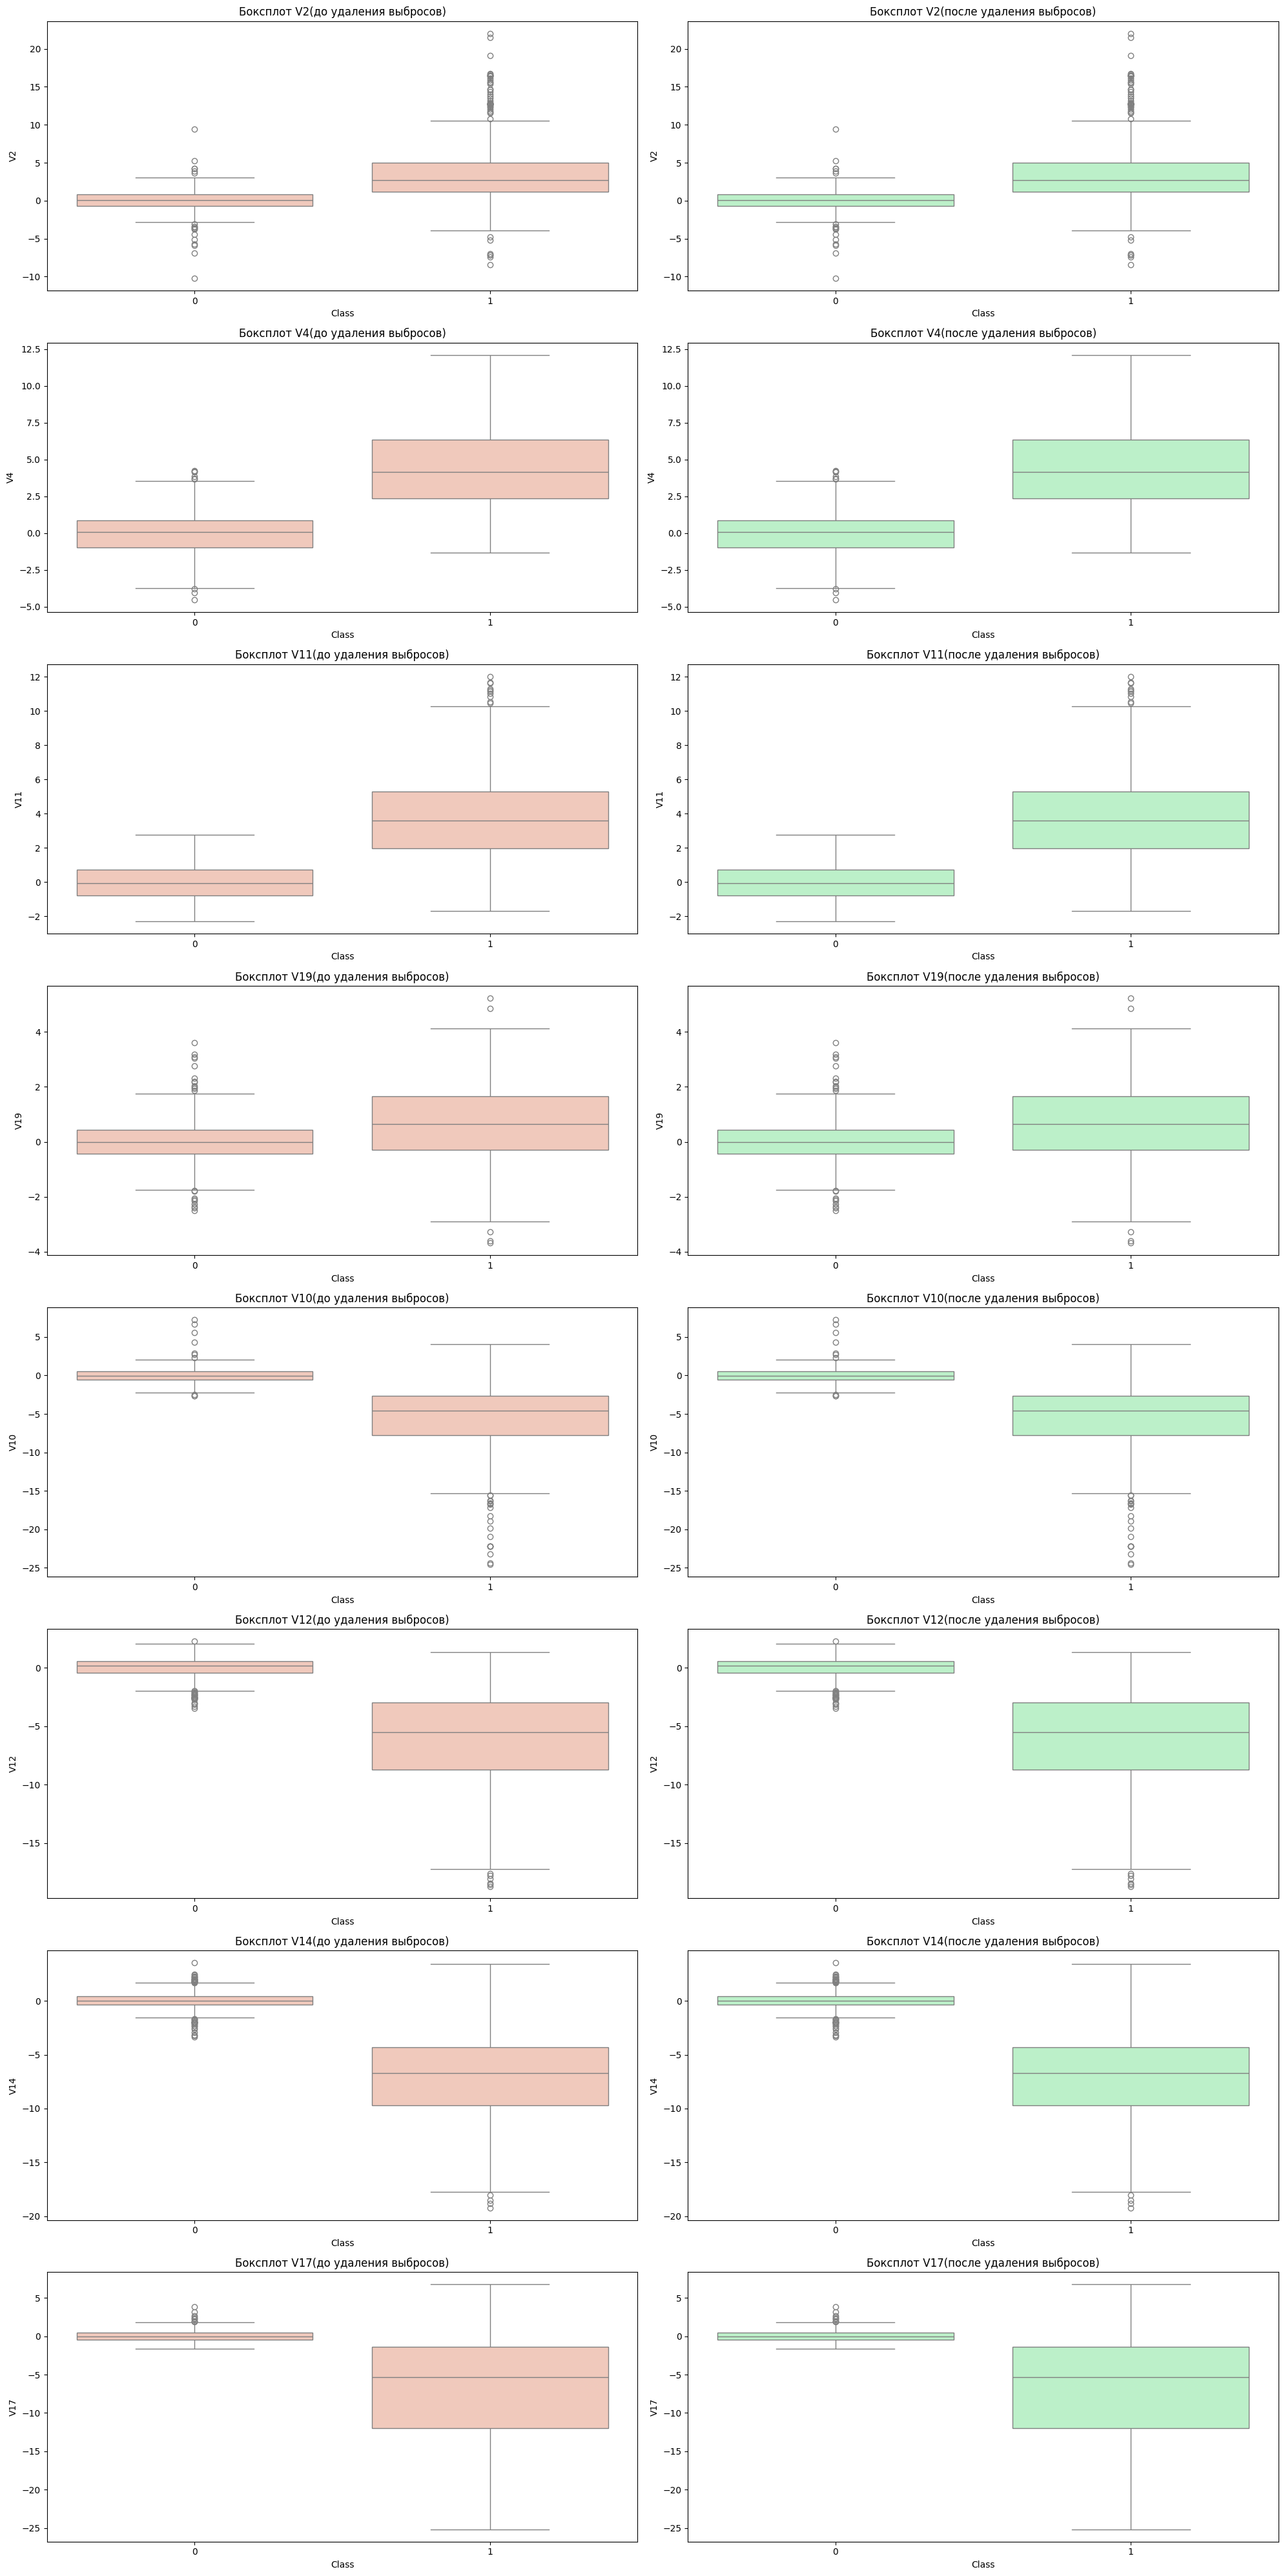

In [47]:
f, ax = plt.subplots(8, 2, figsize=(20,40))

colors = ['#B3F9C5', '#f9c5b3']
features=positive+negative
# Boxplot для признака V17 после удаления выбросов
for i,feature in enumerate(features):
  sns.boxplot(x='Class',y=feature,data=new_df,ax=ax[i,0],color=colors[1])
  ax[i,0].set_title(f'Боксплот {feature}(до удаления выбросов)')

  sns.boxplot(x='Class',y=feature,data=new_df,ax=ax[i,1],color=colors[0])
  ax[i,1].set_title(f'Боксплот {feature}(после удаления выбросов)')

# Boxplot для признака V17 до удаления выбросов


# И для остальных признаков тоже

plt.tight_layout()

plt.show()

In [48]:
# теперь у нас в датафрейме new_df будут лежать данные без выбросов.

new_df = df_without_outliers

In [49]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

X = new_df.drop('Class', axis=1)
y = new_df['Class']

X.drop(['Time','Amount'], axis=1, inplace=True) # Tак как Time и Amount не коррелируют почти с таргетом


# T-SNE алгоритм
t0 = time.time()
tsne=TSNE(n_components=2,random_state=42)
X_reduced_tsne = tsne.fit_transform(X)
# ВАШ КОД ЗДЕСЬ
t1 = time.time()
print("T-SNE заняло {:.2} сек".format(t1 - t0))

# PCA алгоритм
t0 = time.time()
pca=PCA(n_components=2)
# ВАШ КОД ЗДЕСЬ
X_reduced_pca = pca.fit_transform(X)
t1 = time.time()
print("PCA заняло {:.2} сек".format(t1 - t0))

# TruncatedSVD алгоритм
t0 = time.time()
svd=TruncatedSVD(n_components=2)
# ВАШ КОД ЗДЕСЬ
X_reduced_svd = svd.fit_transform(X)
t1 = time.time()
print("Truncated SVD заняло {:.2} сек".format(t1 - t0))

T-SNE заняло 7.8 сек
PCA заняло 0.03 сек
Truncated SVD заняло 0.017 сек


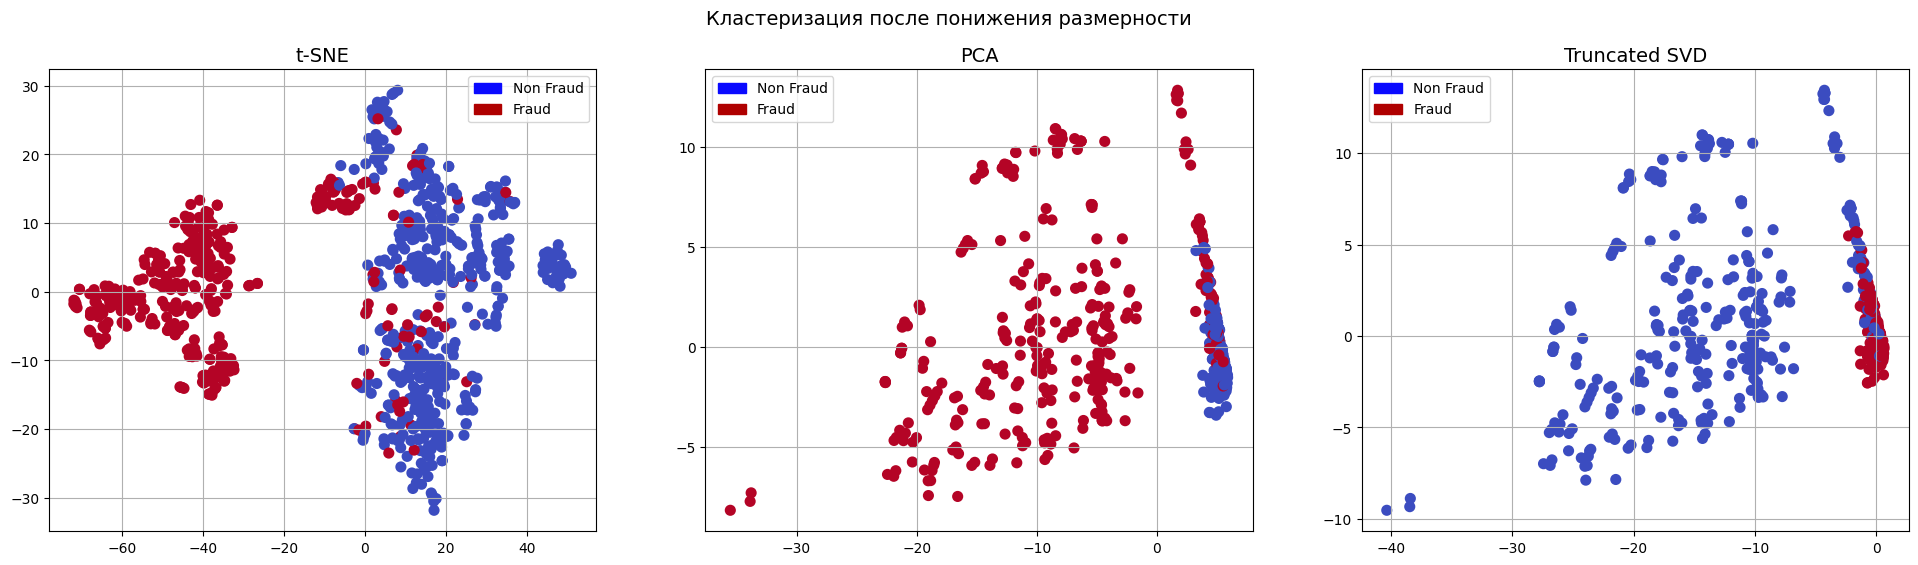

In [53]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
f.suptitle('Кластеризация после понижения размерности', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='Non Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=y, cmap='coolwarm', label='Non Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=y, cmap='coolwarm', label='Non Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='Non Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

In [ ]:
new_df.to_csv('/content/drive/MyDrive/Colab Notebooks/data/creditcard_short.csv')